# Simple Michelson Interferometer


In [1]:
from pykat import finesse                  # Importing the pykat.finesse package
from pykat.commands import *               # Importing all packages in pykat.commands.
from IPython.display import display, HTML  # Allows us to display HTML.
%matplotlib notebook
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)
import numpy as np                         # Importing numpy
import matplotlib                          # For plotting
import matplotlib.pyplot as plt      
# Initialises the PyKat plotting tool. Change dpi value 
# to change figure sizes on your screen.
#pykat.init_pykat_plotting(dpi=32)       

                                              ..-
    PyKat 1.2.2           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



<IPython.core.display.Javascript object>


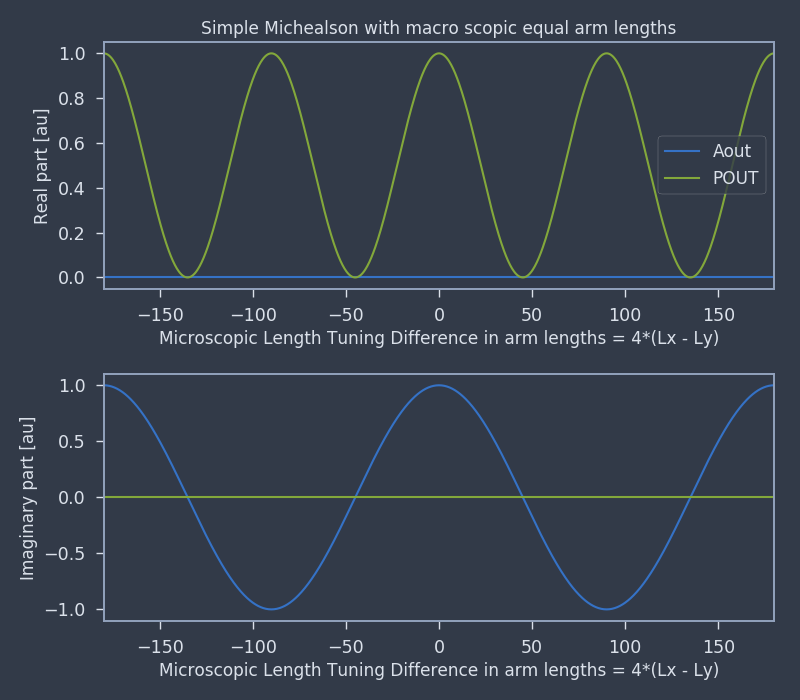

In [3]:
basekat=finesse.kat() # initialising Finesse
basekat.verbose = False
basecode = """
l laser 1 0 0 n0    # Laser (Power = 1 W, wavelength offset = 0, init phase = 0)
s s-w 1 n0 n1       # Space (Length = 1 m)
bs bs1 0.5 0.5 0 45 n1 n2 n3 n4   # Beam splitter R = 0.5, T = 0.5, 
                                  #  phi = 0, AoI = 45
s s-n 1000 n2 n5    # Space 1000m Ly 
m m-n 1 0 0 n5 dump # Mirror_y R = 1, T = 0, phi = 0           
s s-e 1000 n3 n6    # Space 1000m Lx
m m-e 1 0 0 n6 dump # Mirror_x R = 1, T = 0, phi = 0
"""
basekat.parse(basecode) # Parsing the FINESSE-code
detector_code = '''
pd0 POUT n4         # Power Output at Asymmetric Port 
ad Aout 0 n4        # Ampitude Detector at Asymmetric port
'''
simulation_code = '''
xaxis m-n phi lin -180 180 1000
yaxis re:im
put* m-e phi $mx1
'''
kat1 = deepcopy(basekat)
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
#out1.title = "Simple Michealson with equal Arm Lengths"
out1.xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)"
out1.plot(title = "Simple Michealson with macro scopic equal arm lengths")

**Note** : From the above graphs we can see that dark fringe appears when micro scopic path length difference is $\delta L / \lambda = 0.5$

# Simple Michealson With Phase modulator

### Find correct demodulation phase so that the differential arm length change appears at Asymmetric Port Quadrature Signal.
Instead of varying the demodulator phase, space between EOM and beam splitter is varied.

In [4]:
#Kat code describing Simple Michealson with phase modulator 
basekat_pm=finesse.kat() # initialising Finesse
basecode_pm = """
l laser 1 0 n0                      # Laser (Power = 1 W, wavelength offset = 0)
s sw 1 n0 nn1                      # Space (Length = 1 m)
mod eom1 9M 0.45 1 pm nn1 nn2       # Eom mod freq = 3MHz Lamda Mod ~ 33.33m 
s seom 33 nn2 n1      # Space between the EOM and input to interferometer
                            # is adjust such that difference in path lengths is
                            # observed at Quadrature and common path length changes
                            # are observed as In Phase signals.
bs bs1 0.5 0.5 0 45 n1 n2 n3 n4     # Beam Splitter R = 0.5, T = 0.5, phi = 0, 
                                    # AoI = 45 
s sn 1000 n2 n5             # Space BS and Mirror Y (Length Ly = 1000m)
m mn 1 0 0 n5 dump         # Mirror Y (R = 1)
s se 1000 n3 n6             # Space BS and Mirror X (Length Lx = 1000m)
m me 1 0 0 n6 dump         # Mirror X (R = 1)
"""
basekat_pm.parse(basecode_pm)

In [5]:
# Instead of tuning for appropriate phase of demodulator, space between EOM and BS
# is adjusted such that difference in imag part of sidebands is zero. At that point 
# Difference in path lengths will be observed only at Asymmetric Quadrature.
kat_Q_optimize = finesse.kat()
kat_Q_optimize.verbose = False;
kat_Q_optimize.parse(basecode_pm)
detector_code = '''
ad Aout_lower -9M n4
ad Aout_upper 9M n4
'''
simulation_code = '''
xaxis seom L lin 25 40 1000
yaxis re:im
noxaxis
'''
kat_Q_optimize.parse(detector_code);
kat_Q_optimize.parse(simulation_code);

# Function takes input for space between EOM and BS 
def f(L):
    kat_Q_optimize.seom.L = L;
    res = kat_Q_optimize.run();
    return (res['Aout_upper'] - res['Aout_lower']).imag

# Find the 'L' such that difference of imag part of side band is zero 
from scipy import optimize
sol = optimize.root_scalar(f, bracket=[25.0, 40.0], method='brentq')
print ("Space between EOM and BS = " + str(sol.root) + 
       " to get difference in arms lengths only at ASQ (Asymmetric Port Quadrature)")

# set distance between EOM and BS
seom_length = sol.root;

Space between EOM and BS = 31.9266597778 to get difference in arms lengths only at ASQ (Asymmetric Port Quadrature)


<IPython.core.display.Javascript object>


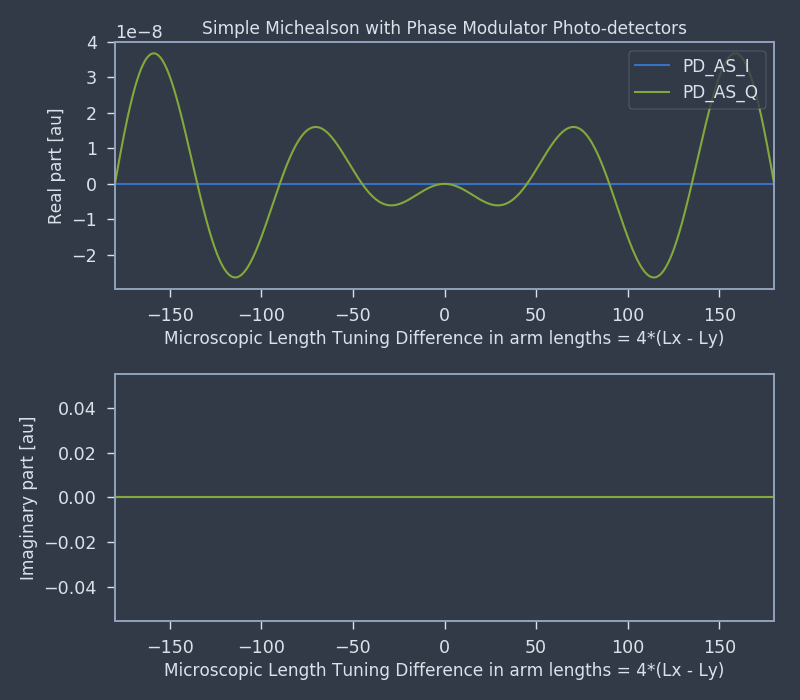

<IPython.core.display.Javascript object>


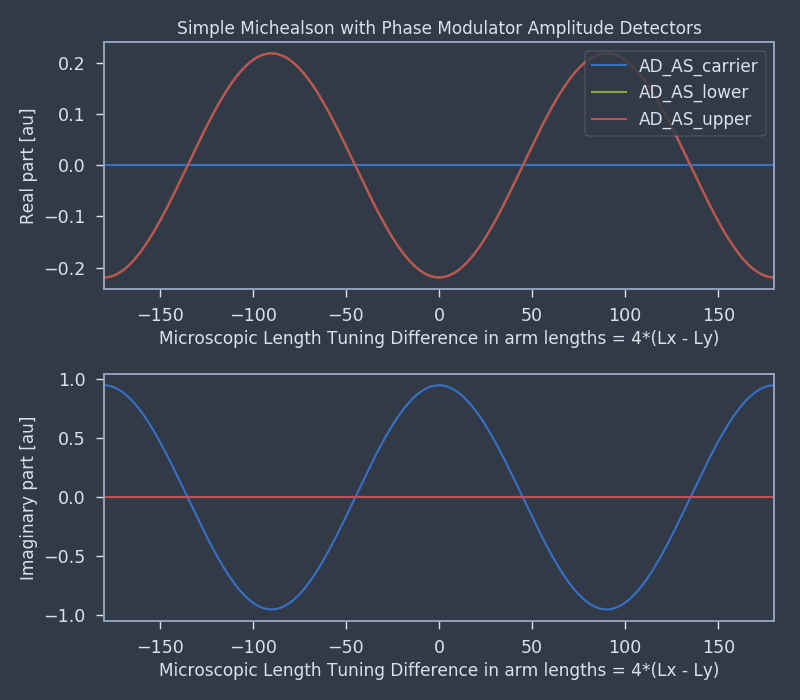

In [6]:
# Plots to show the amplitude of side bands and carrier, demodulated PD signals, 
# and carrier power vs variation of the microscopic differential length variation
# Note in these plots there is not variation of common mode length variation (Lx + Ly) 
kat1 = finesse.kat()
kat1.verbose = False
kat1.parse(basecode_pm) # Parsing the FINESSE-code
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis mn phi lin -180 180 1000 #Mirror Y is varied -180 to 180 
put* me phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat1.seom.L = seom_length 
#delta_L = 0
#kat1.sn.L = 1000.0 - delta_L
#kat1.se.L = 1000.0 + delta_L
kat1.parse(detector_code);
kat1.parse(simulation_code);
out1 = kat1.run()
out1.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Simple Michealson with Phase Modulator Photo-detectors",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out1.plot(detectors = ['AD_AS_carrier', 'AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Simple Michealson with Phase Modulator Amplitude Detectors",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

### Schnupp Asymmetry 
In the above example, operating point of is at macroscopic length difference to zero. Below are examples with macroscopic asymmetry with different lengths.

<IPython.core.display.Javascript object>


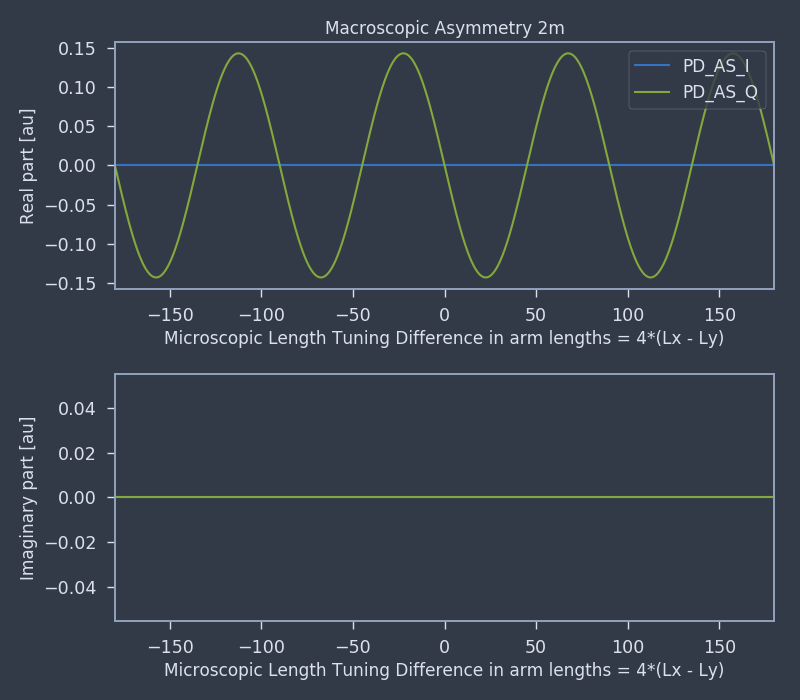

<IPython.core.display.Javascript object>


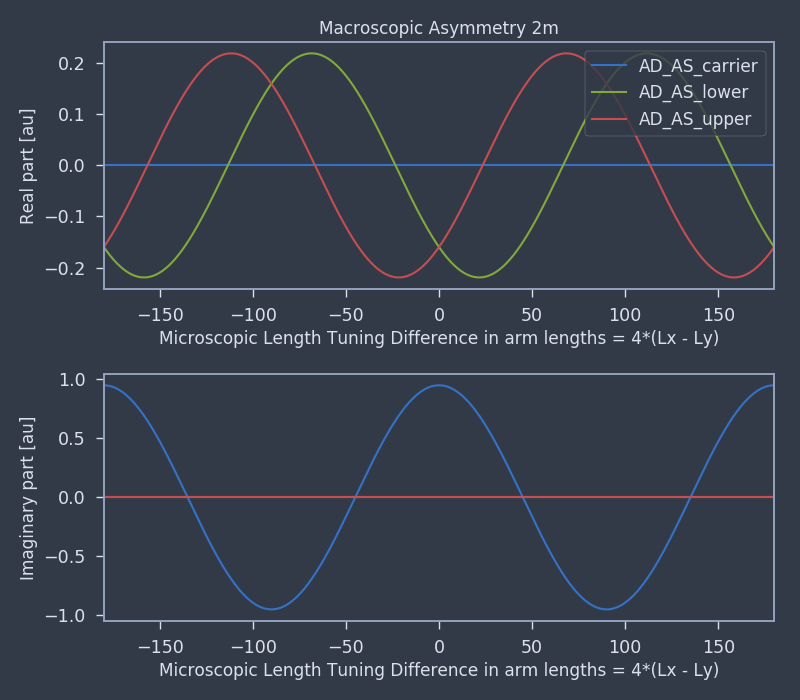

<IPython.core.display.Javascript object>


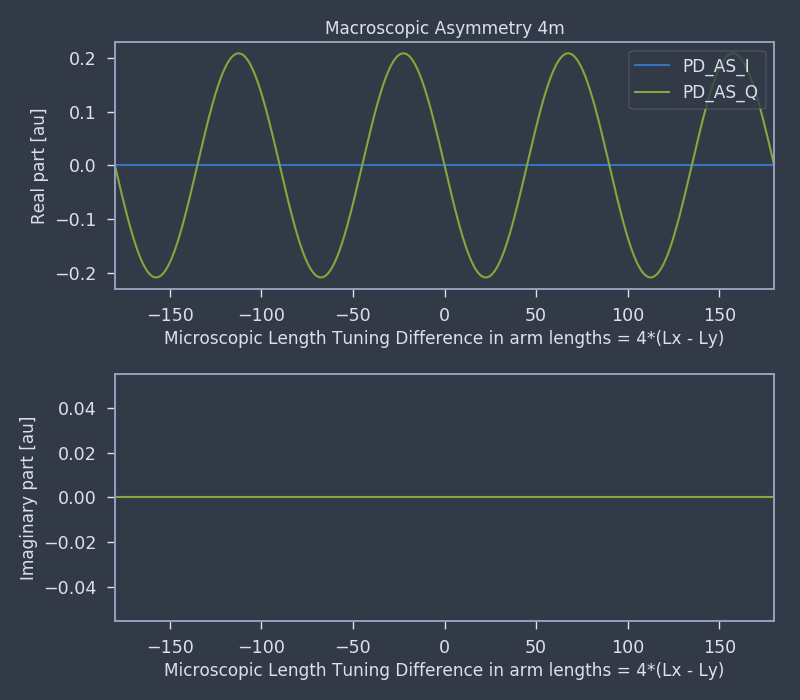

<IPython.core.display.Javascript object>


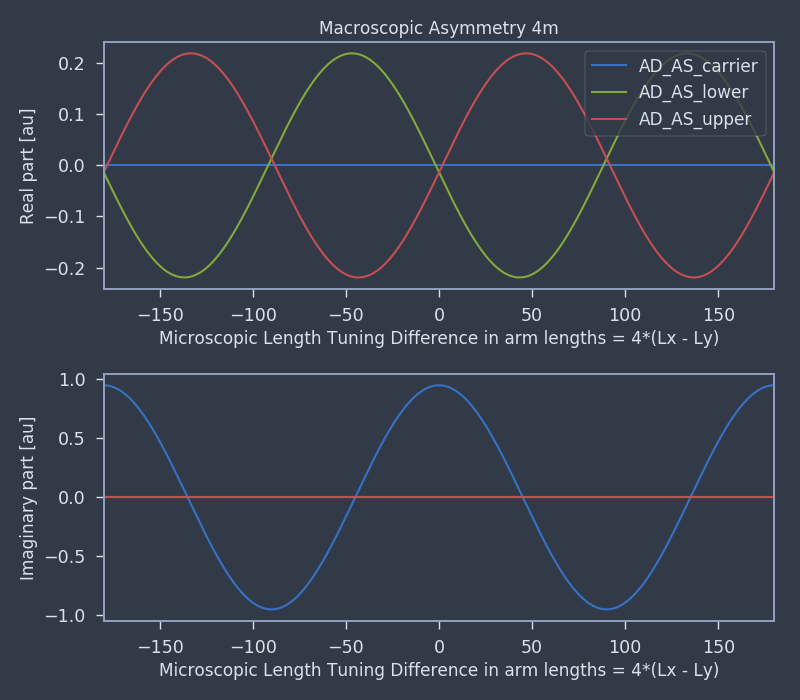

In [7]:
# Repeat the above with different macroscopic asymmetry settings.
kat2 = kat1.deepcopy()
delta_L = 2.0
kat2.sn.L = 1000.0 - delta_L
kat2.se.L = 1000.0 + delta_L
kat2.parse('yaxis re:im')
out2 = kat2.run()
out2.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Macroscopic Asymmetry 2m",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out2.plot(detectors = ['AD_AS_carrier', 'AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Macroscopic Asymmetry 2m",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
kat3 = kat1.deepcopy()
delta_L = 4.0
kat3.sn.L = 1000.0 - delta_L
kat3.se.L = 1000.0 + delta_L
kat3.parse('yaxis re:im')
out3 = kat3.run()
out3.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Macroscopic Asymmetry 4m",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out3.plot(detectors = ['AD_AS_carrier', 'AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Macroscopic Asymmetry 4m",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")

In the above plots observe the sidebands amplitude at zero crossing of the carrier, that is dark fringe for the carrier. We also see the increase in PD_AS_Q (demodulated quadrature signal at asymmetric port), due to the asymmetry. Figure below, is the plot of PD_AS_Q signal at various asymmetries.  

<IPython.core.display.Javascript object>


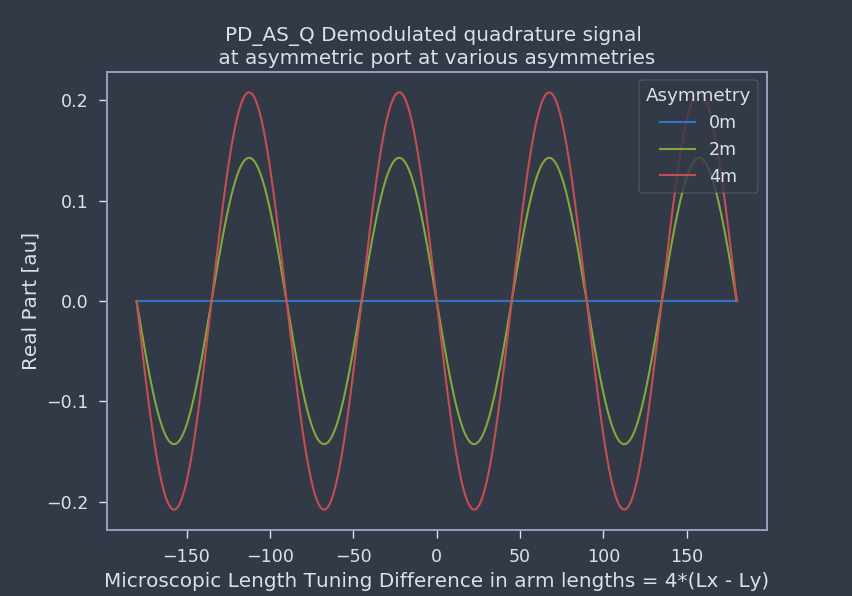

/home/sivananda/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [8]:
# Plot Showing PD_AS_Q at various arm length asymmetries. 
fig, ax = plt.subplots() 
ax.plot(out1.x, out1['PD_AS_Q'], label = "0m")  
ax.plot(out2.x, out2['PD_AS_Q'], label = "2m")  
ax.plot(out3.x, out3['PD_AS_Q'], label = "4m") 
ax.set_xlabel('Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)')
ax.set_ylabel('Real Part [au]')  
ax.set_title("PD_AS_Q Demodulated quadrature signal \n at asymmetric port at various asymmetries ")  
ax.legend(title = "Asymmetry", loc = 'upper right')  # Add a legend.
plt.show()

#### Optimize schnupp asymmetry for maximizing  quadrature signal at asymmetric port for simple michealson with phase modulator
Find asymmetry such that signal peak to peak is maximum.

In [21]:
# Optimize asymmetry for maximizing PD_AS_Q
kat4 = finesse.kat()
kat4.verbose = False
kat4.parse(basecode_pm)
kat4.seom.L = seom_length
detector_code = '''
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
'''
simulation_code = '''
xaxis mn phi lin 0 90 10000 #Mirror Y is varied -180 to 180 
put* me phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat4.parse(detector_code)
kat4.parse(simulation_code)

def f(delta_L):
    kat4.sn.L = 1000.0 - delta_L
    kat4.se.L = 1000.0 + delta_L
    out4 = kat4.run()
    pk_to_pk = abs(max(out4['PD_AS_Q']) - 
                   min(out4['PD_AS_Q'])) #return peak to peak difference
    return -1.0 * pk_to_pk

from scipy import optimize
res = optimize.minimize_scalar(f,bounds = (0.0, 33))
schnupp_dL= res.x
print res
print "Asymmetry for Maximum PD_AS_Q = " + str(res.x)
print "Modulation Wavelength PD_AS_Q = " + str(seom_length)

     fun: -0.416775146497638
    nfev: 24
     nit: 19
 success: True
       x: 4.163783882565459
Asymmetry for Maximum PD_AS_Q = 4.163783882565459
Modulation Wavelength PD_AS_Q = 31.9266597778


<IPython.core.display.Javascript object>


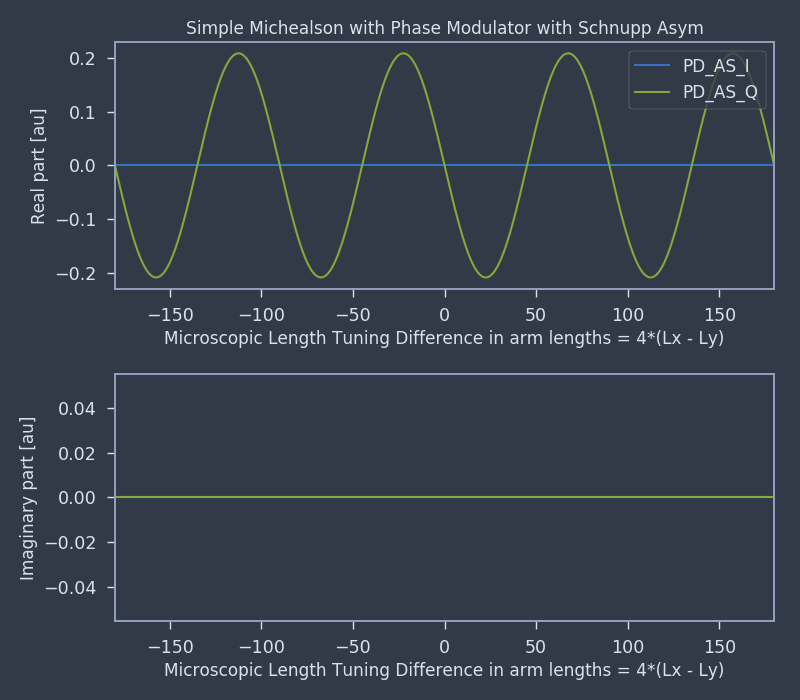

<IPython.core.display.Javascript object>


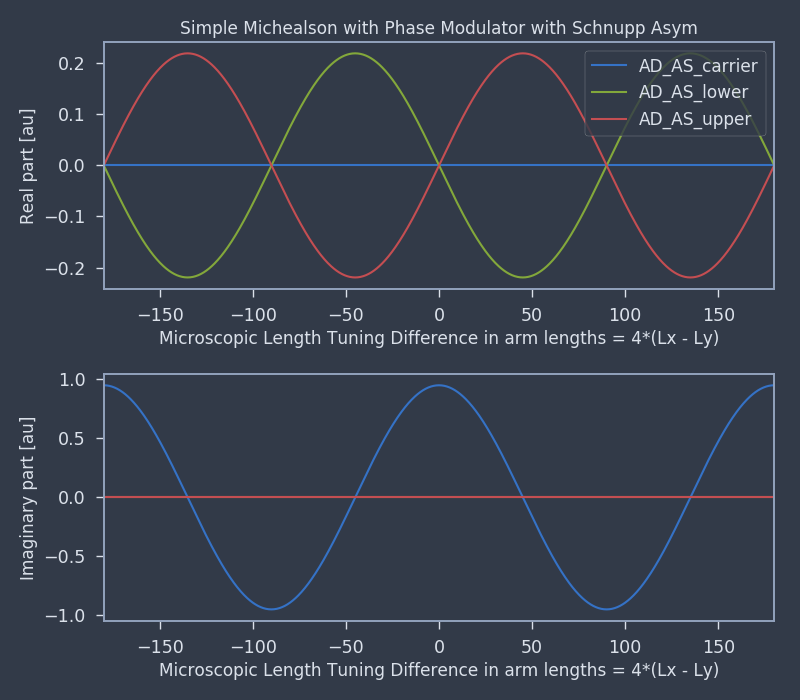

In [23]:
# plot the results with schnupp asymmetry
detector_code = '''
pd0 PD_AS n4             #Carrier Power at Asymmetric port
pd1 PD_AS_I 9M 0 n4      #Demodulated Asymmetric port In phase 
pd1 PD_AS_Q 9M 90 n4     #Demodulated Asymmetric port Quadrature
ad AD_AS_carrier 0 n4    #Carrier Amplitude at Asymmetric port 
ad AD_AS_lower -9M n4    #Lower Sideband Amplitude at Asymmetric port
ad AD_AS_upper 9M n4     #Upper Sideband Amplitude at Asymmetric port
'''
simulation_code = '''
xaxis mn phi lin -180 180 1000 #Mirror Y is varied -180 to 180 
put* me phi $mx1               #Mirror X is varied 180 to 180
yaxis re:im
'''
kat4.seom.L = seom_length 

delta_L = schnupp_dL
kat4.sn.L = 1000.0 - delta_L
kat4.se.L = 1000.0 + delta_L
kat4.parse(detector_code);
kat4.parse(simulation_code);
out4 = kat4.run()
out4.plot(detectors = ['PD_AS_I', 'PD_AS_Q'], loc = 'upper right',
         title = "Simple Michealson with Phase Modulator with Schnupp Asym",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")
out4.plot(detectors = ['AD_AS_carrier', 'AD_AS_lower', 'AD_AS_upper'], loc = 'upper right',
         title = "Simple Michealson with Phase Modulator with Schnupp Asym",
         xlabel = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)",
         x2label = "Microscopic Length Tuning Difference in arm lengths = 4*(Lx - Ly)")